In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
# Define data directory paths
train_data_dir = '/content/drive/MyDrive/Metal Surface Defects Data/test'
test_data_dir = '/content/drive/MyDrive/Metal Surface Defects Data/train'
valid_data_dir = '/content/drive/MyDrive/Metal Surface Defects Data/valid'

In [ ]:
# Define class names
class_names = ['Crazing','Hole','Inclusion','Patches','Pitted','Rolled','Scratches']

# Data Augmentation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [ ]:
# Data Generators
batch_size = 32
input_shape = (200, 200, 3)
num_classes = len(class_names)


train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

valid_generator = datagen.flow_from_directory(
    valid_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 84 images belonging to 7 classes.
Found 1851 images belonging to 7 classes.
Found 84 images belonging to 7 classes.


In [ ]:
for image_batch, labels_batch in train_generator:
    print("Batch Shape (Images):", image_batch.shape)
    print("Batch Shape (Labels):", labels_batch.shape)
    break

Batch Shape (Images): (32, 200, 200, 3)
Batch Shape (Labels): (32, 7)


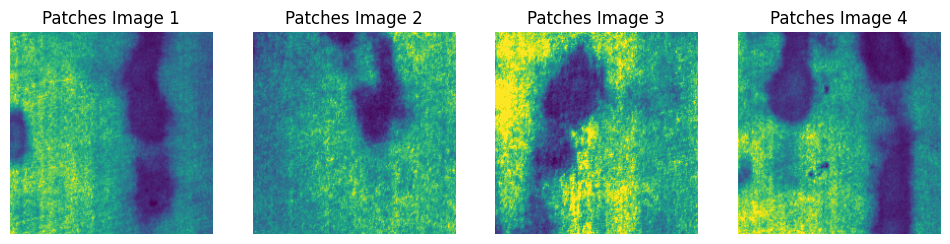

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

class_name = 'Patches'
class_dir = os.path.join(train_data_dir, class_name)
sample_images = random.sample(os.listdir(class_dir), 4)

plt.figure(figsize=(12, 6))
for i, image_file in enumerate(sample_images):
    plt.subplot(1, 4, i + 1)
    image = mpimg.imread(os.path.join(class_dir, image_file))
    plt.imshow(image)
    plt.title(f'{class_name} Image {i + 1}')
    plt.axis('off')

plt.show()

# VGG16

In [ ]:
!pip install tensorflow_addons

In [ ]:
# Create a custom classification model with AdamW optimizer
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa # for adamW

# Create a VGG16 model with pre-trained weights (include_top=False to exclude the top layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Create your custom classification head
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Define the AdamW optimizer
optimizer = tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4)

In [ ]:
# Compile the model with the AdamW optimizer
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True)

In [ ]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24155975 (92.15 MB)
Trainable params: 24155975 (92.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=35,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/35
3/3 [==============================] - 41s 10s/step - loss: 2.6573 - accuracy: 0.1071 - val_loss: 2.2107 - val_accuracy: 0.1429
Epoch 2/35
3/3 [==============================] - 5s 2s/step - loss: 2.2725 - accuracy: 0.1667 - val_loss: 1.9406 - val_accuracy: 0.2024
Epoch 3/35
3/3 [==============================] - 5s 2s/step - loss: 2.0363 - accuracy: 0.1786 - val_loss: 1.8036 - val_accuracy: 0.2857
Epoch 4/35
3/3 [==============================] - 3s 1s/step - loss: 1.9745 - accuracy: 0.2619 - val_loss: 1.6749 - val_accuracy: 0.3214
Epoch 5/35
3/3 [==============================] - 3s 1s/step - loss: 1.8762 - accuracy: 0.2976 - val_loss: 1.5519 - val_accuracy: 0.4881
Epoch 6/35
3/3 [==============================] - 4s 1s/step - loss: 1.7338 - accuracy: 0.4405 - val_loss: 1.4351 - val_accuracy: 0.5238
Epoch 7/35
3/3 [==============================] - 4s 2s/step - loss: 1.5353 - accuracy: 0.4405 - val_loss: 1.3140 - val_accuracy: 0.5000
Epoch 8/35
3/3 [=======================

In [ ]:
# Save the entire model
model.save('/content/drive/MyDrive/Metal Surface Defects Data/metal_defects_model.h5')

# Load the saved model
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/Metal Surface Defects Data/metal_defects_model.h5')

# Convert the model to TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)

# Add quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model to TensorFlow Lite format
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = '/content/drive/MyDrive/Metal Surface Defects Data/metal_defects_model_quantized2.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f'TFLite model with quantization saved to: {tflite_model_path}')

TFLite model with quantization saved to: /content/drive/MyDrive/Metal Surface Defects Data/metal_defects_model_quantized2.tflite


# Accuracy and Loss Graph

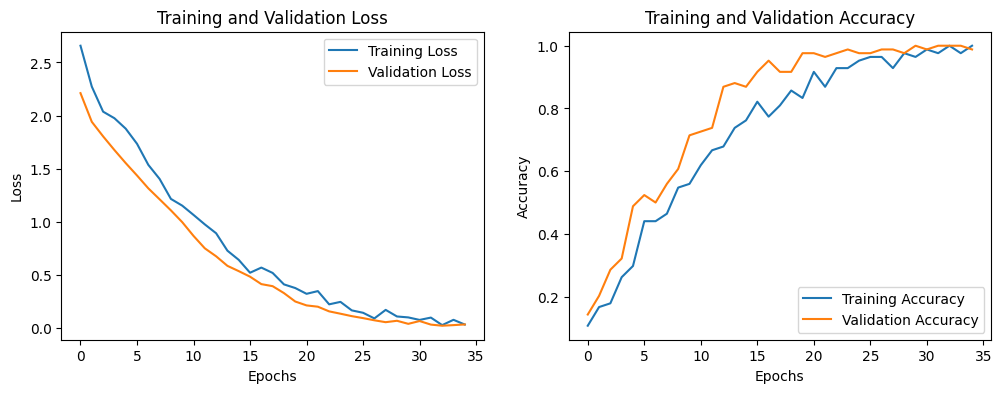

In [ ]:
plt.figure(figsize=(12, 4))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

# Print the test loss and accuracy
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

58/58 [==============================] - 32s 551ms/step - loss: 0.1811 - accuracy: 0.9314
Test Loss: 0.18107396364212036
Test Accuracy: 0.9313884377479553


# Confusion Matrix

58/58 [==============================] - 27s 456ms/step


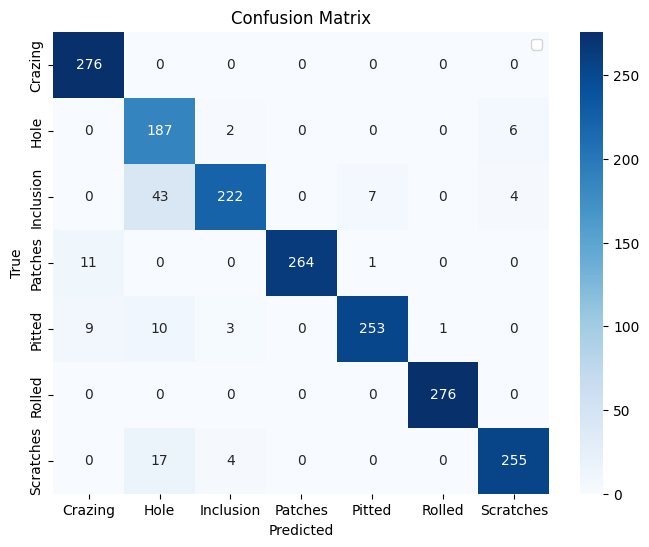

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the true labels
true_labels = test_generator.classes

# Get the predicted labels
predicted_labels = model.predict(test_generator)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.legend()
plt.show()

# Prediction Examples

1/1 [==============================] - 3s 3s/step


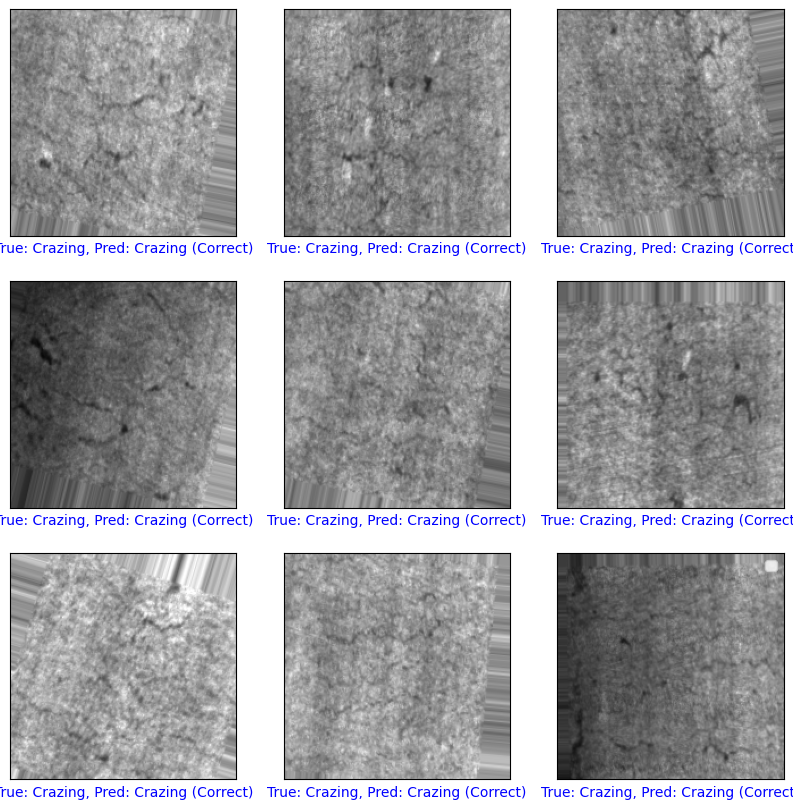

In [ ]:
images, labels = next(test_generator)

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = model.predict(images)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = images[i]

    if image.shape[-1] == 1:
        image = np.squeeze(image)

    plt.imshow(image)

    predicted_label = np.argmax(predictions[i])

    if predicted_label == np.argmax(labels[i]):
        color = 'blue'
        result_text = "Correct"
    else:
        color = 'red'
        result_text = "Incorrect"

    label_text = "True: " + class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"

    plt.xlabel(label_text, color=color)

plt.legend()
plt.show()